

# Removing muscle ICA components - Laboratory 9

Usage of the MNE tool when making the ICA EEG analysis

In [ ]:
# Authors: Nicolas Arango, Leon Acahata, Hans Navarro

Creating RawArray with float64 data, n_channels=8, n_times=180227
    Range : 0 ... 180226 =      0.000 ...   720.904 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)



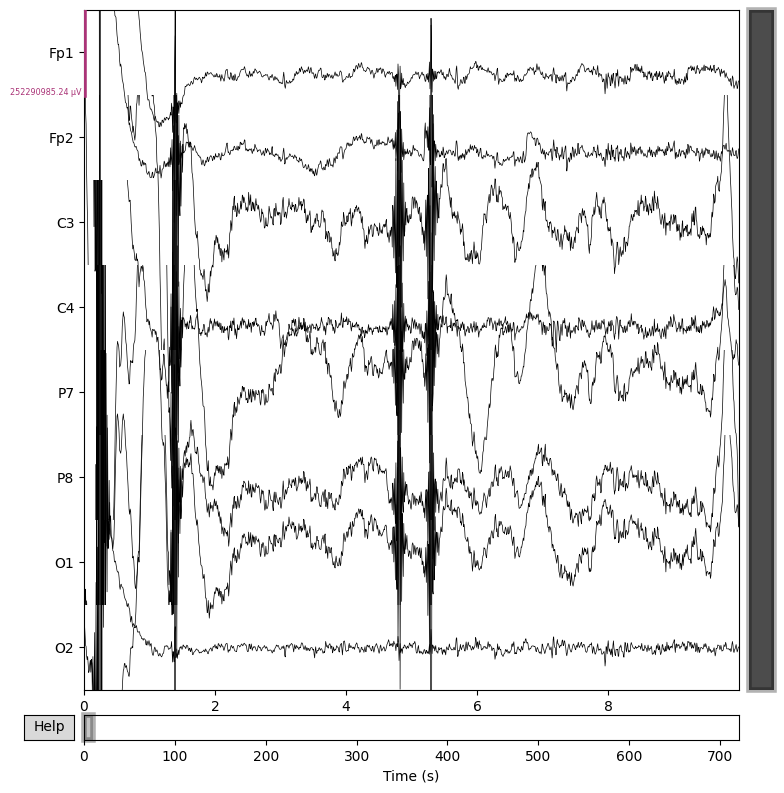

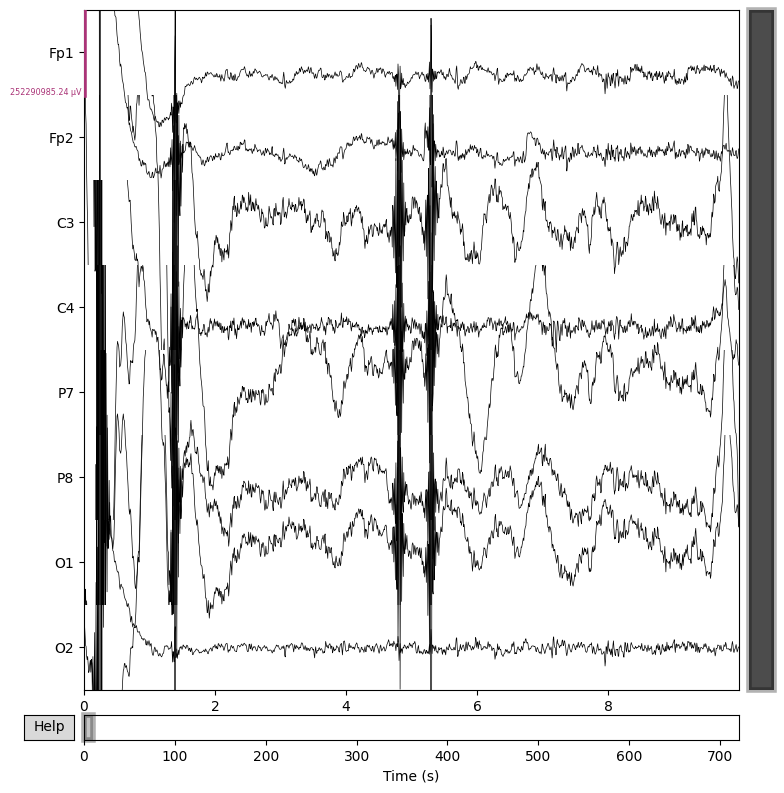

In [ ]:
import mne
import pandas as pd

# Load OpenBCI file
file_path = "OpenBCI-RAW-2025-09-17_12-45-51.txt"

# Read OpenBCI data
df = pd.read_csv(file_path, comment='%')

# Extract the 8 EEG channels
eeg_data = df.iloc[:, 1:9].to_numpy().T  # shape: (n_channels, n_times)
sfreq = 250  # Hz

# Define channel names and types
ch_names = ['Fp1','Fp2','C3','C4','P7','P8','O1','O2']
ch_types = ['eeg'] * 8

# Create MNE Raw object
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
raw = mne.io.RawArray(eeg_data, info)

# Set standard 10–20 montage (for correct channel positions)
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, on_missing='ignore')

# Preprocessing
raw.load_data()
raw.filter(l_freq=1.0, h_freq=40.0)  # band-pass filter for ICA

# Visual check
raw.plot(n_channels=8, scalings='auto')


Run ICA



In [14]:
ica = mne.preprocessing.ICA(
    n_components=None, method='fastica', random_state=97
)
ica.fit(raw)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 8 components
Fitting ICA took 1.1s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=1000
Fit,18 iterations on raw data (180227 samples)
ICA components,8
Available PCA components,8
Channel types,eeg
ICA components marked for exclusion,—


Remove components with postural muscle artifact using ICA



Creating RawArray with float64 data, n_channels=8, n_times=180227
    Range : 0 ... 180226 =      0.000 ...   720.904 secs
Ready.


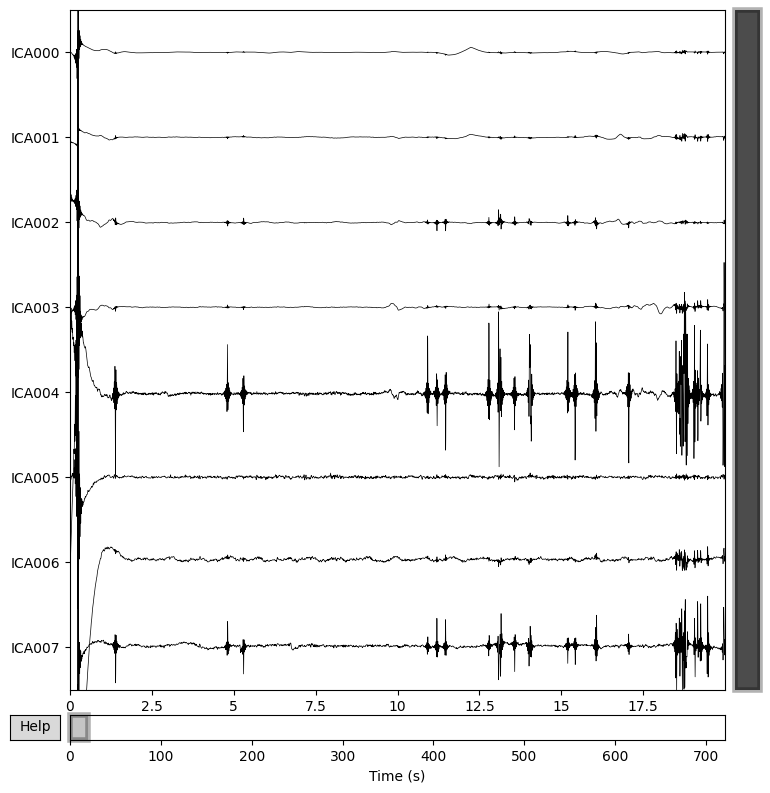

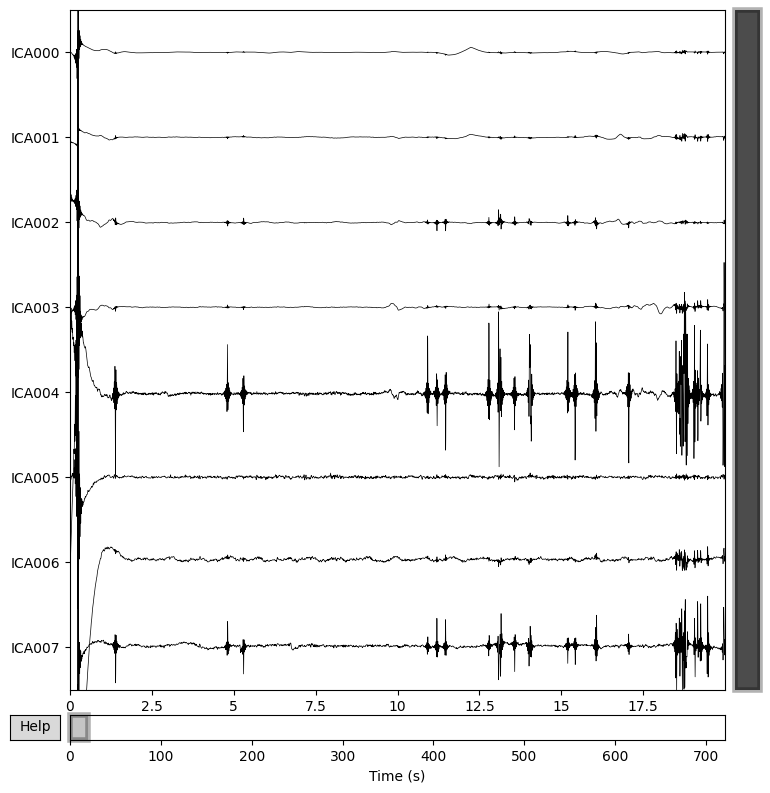

In [15]:
ica.plot_sources(raw)

By inspection, let's select out the muscle-artifact components based on
:footcite:`DharmapraniEtAl2016` manually.

The criteria are:

- Positive slope of log-log power spectrum between 7 and 75 Hz
  (here just flat because it's not in log-log)
- Peripheral focus or dipole/multi-pole foci (the blue and red
  blobs in the topomap are far from the vertex where the most
  muscle is)
- Single focal point (low spatial smoothness; there is just one focus
  of the topomap compared to components like the first ones that are
  more likely neural which spread across the topomap)

The other attribute worth noting is that the time course in
:func:`mne.preprocessing.ICA.plot_sources` looks like EMG; you can
see spikes when each motor unit fires so that the time course looks fuzzy
and sometimes has large spikes that are often at regular intervals.

ICA component 13 is a textbook example of what muscle artifact looks like.
The focus of the topomap for this component is right on the temporalis
muscle near the ears. There is also a minimum in the power spectrum at around
10 Hz, then a maximum at around 25 Hz, generally resulting in a positive
slope in log-log units; this is a very typical pattern for muscle artifact.



    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
360 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
360 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
360 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
360 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
360 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
360 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
360 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
360 matching events found
No baseline correction applied
0 projection items activated


C:\Users\ASUS\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.canvas.print_figure(bytes_io, **kw)


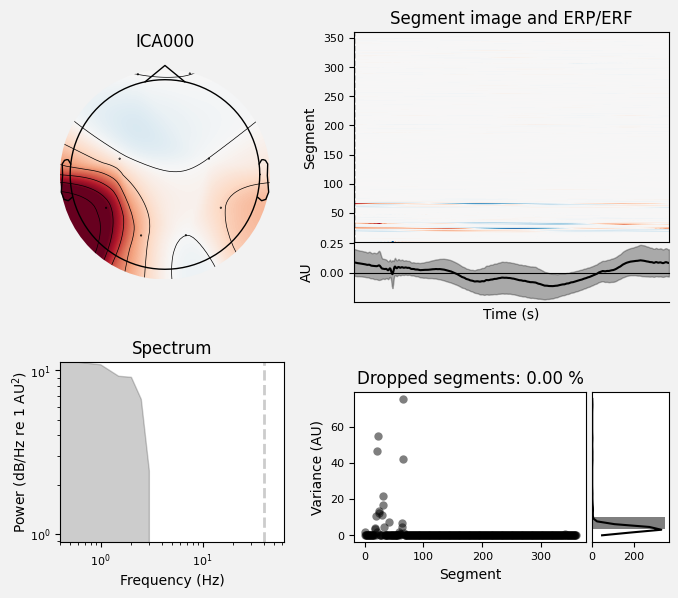

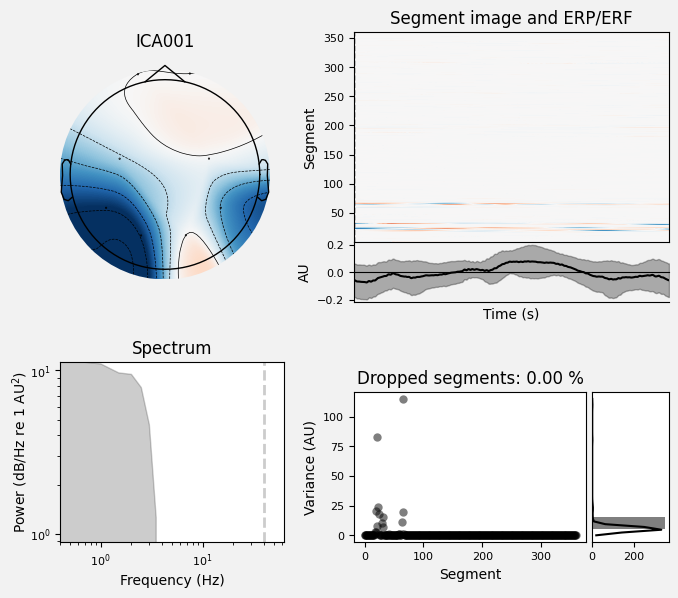

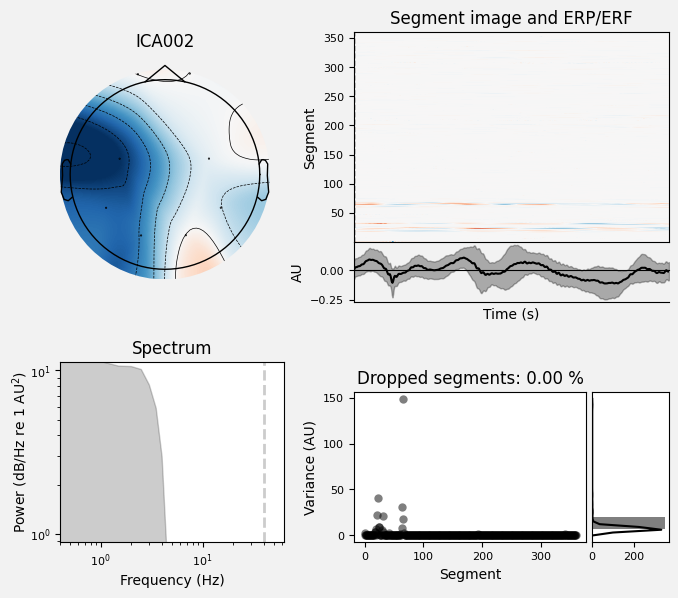

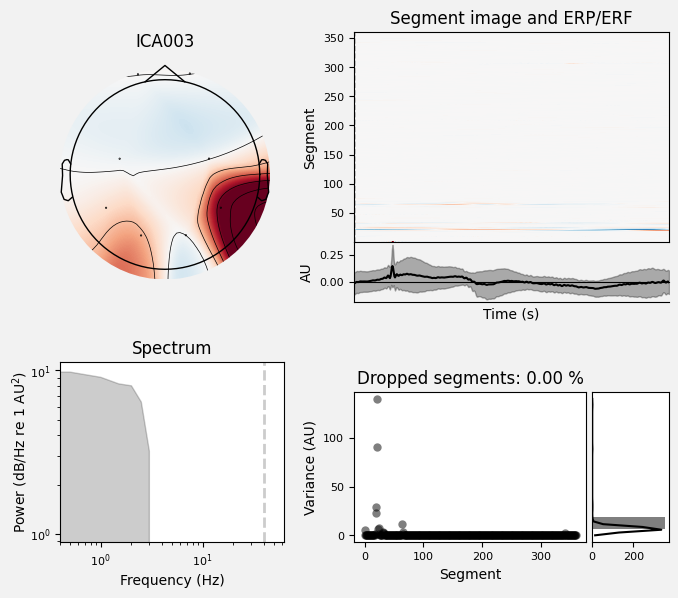

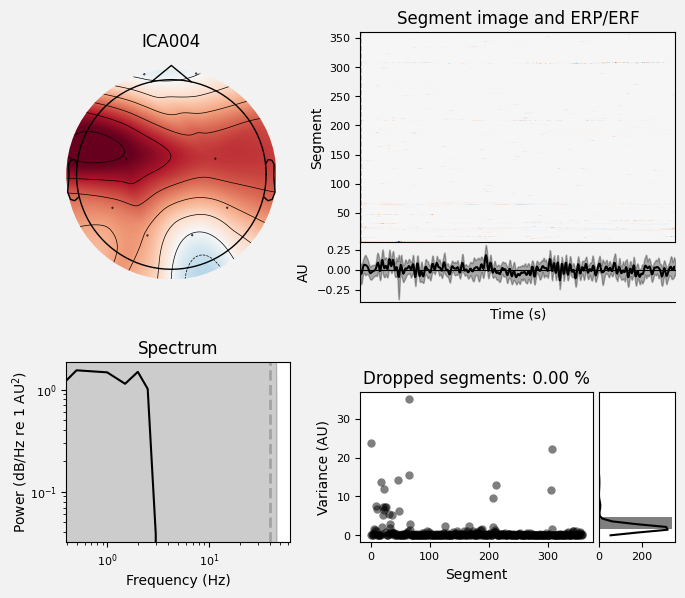

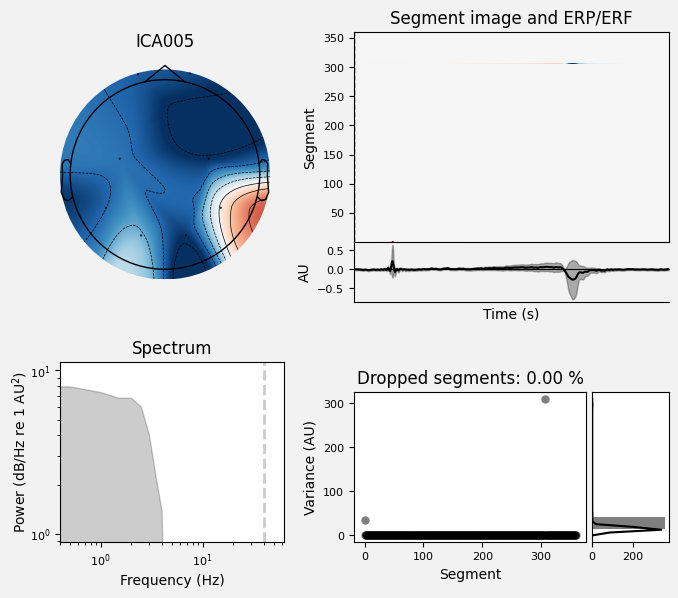

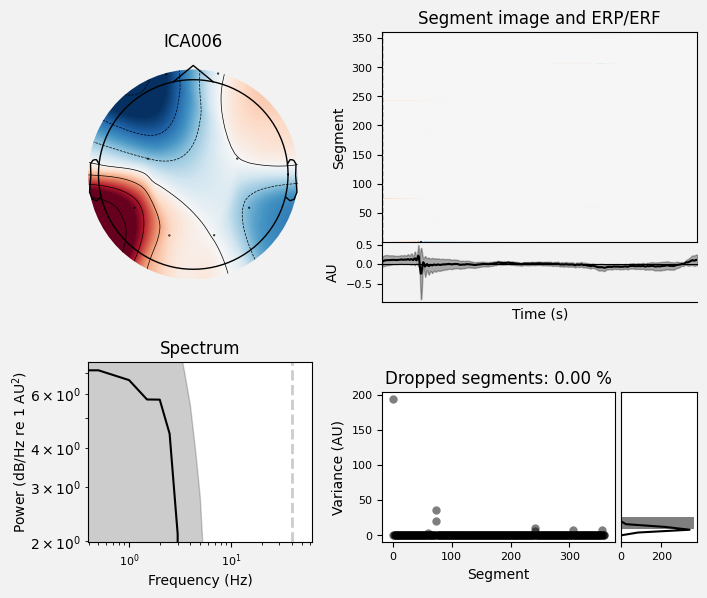

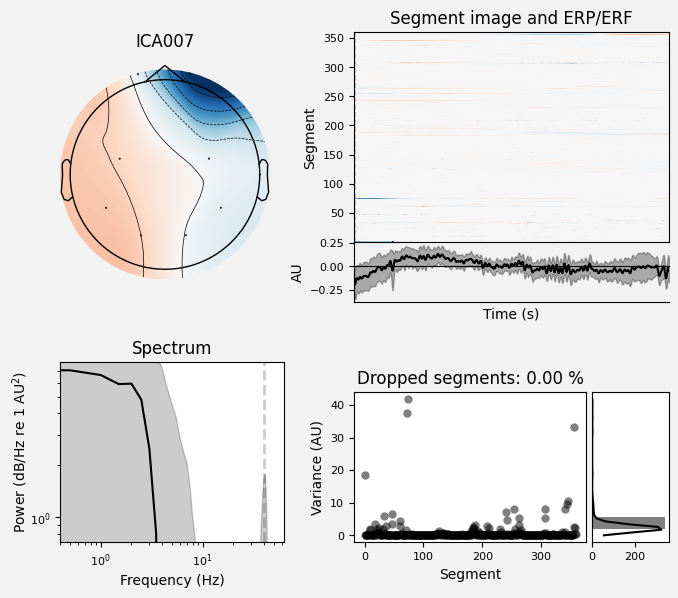

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [16]:
idx = [0, 1, 2, 3, 4, 5, 6, 7]
ica.plot_properties(raw, picks=idx, log_scale=True)

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
360 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
360 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
360 matching events found
No baseline correction applied
0 projection items activated


C:\Users\ASUS\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig.canvas.print_figure(bytes_io, **kw)


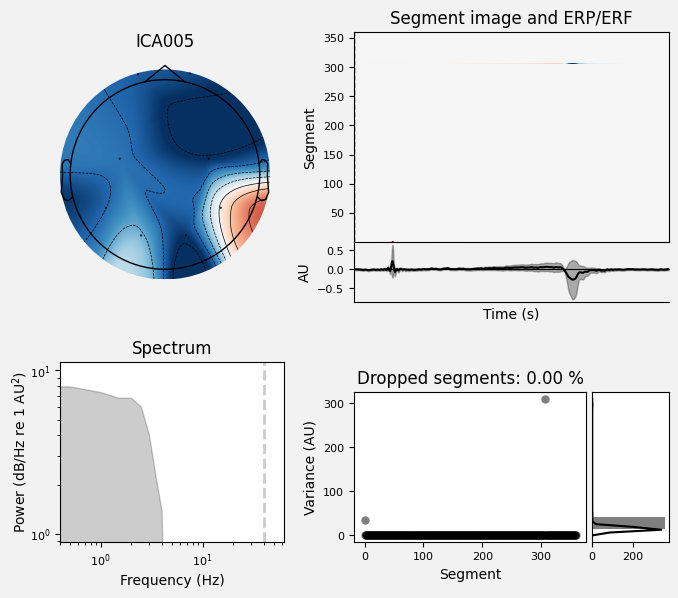

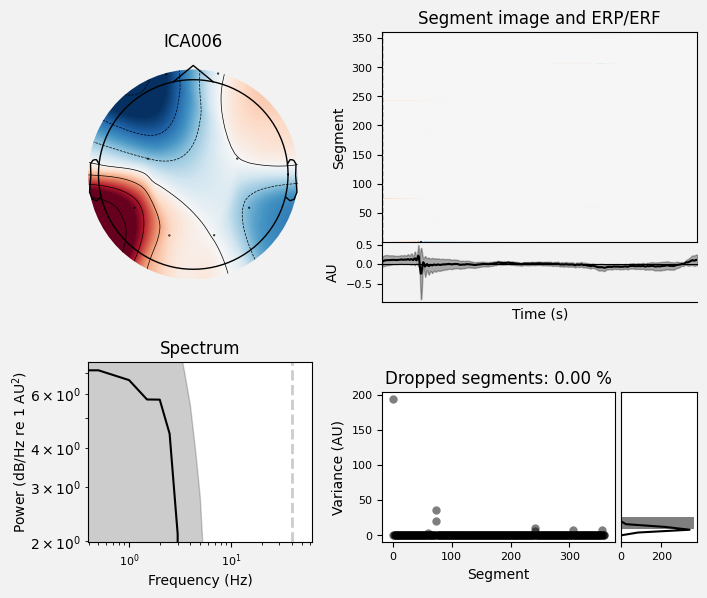

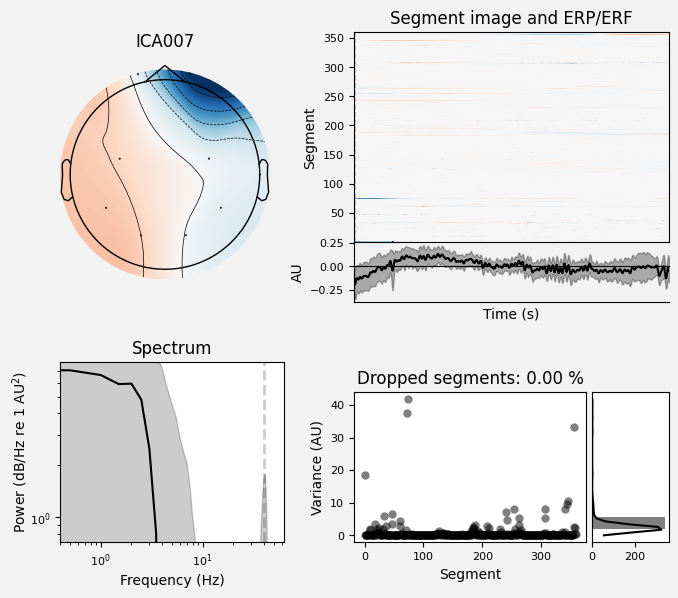

Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 5 ICA components
    Projecting back using 8 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components


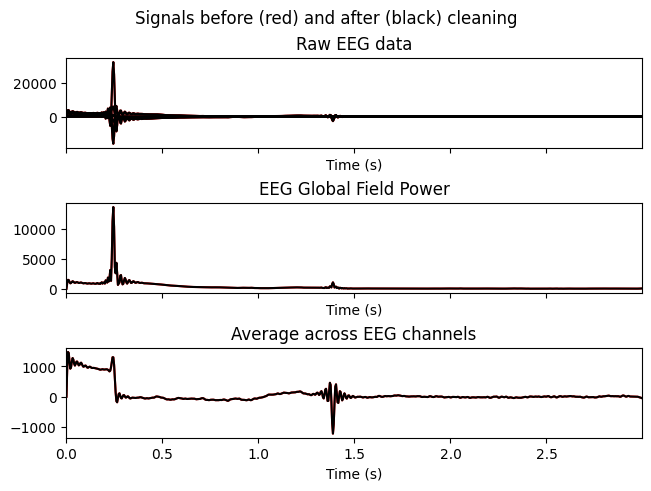

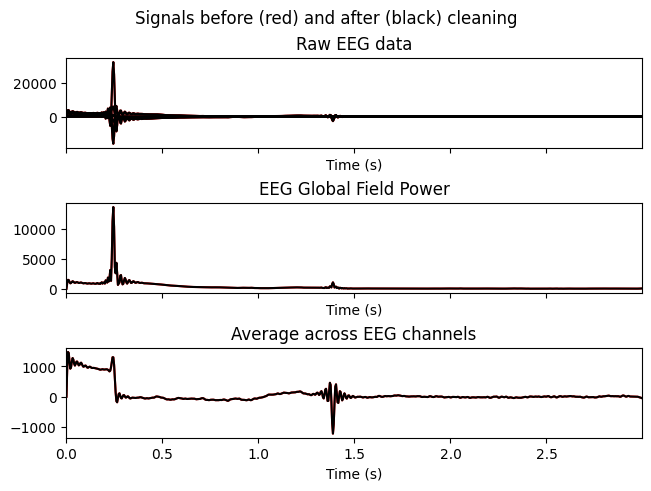

In [ ]:
# Identify muscle components within the valid range (0–7)
muscle_idx = [5, 6, 7] 

# Plot their properties
ica.plot_properties(raw, picks=muscle_idx, log_scale=True)

# Remove blink and heartbeat artifacts 
blink_idx = [0]       
heartbeat_idx = [2]   

# Apply ICA excluding the chosen components
ica.apply(raw, exclude=blink_idx + heartbeat_idx + muscle_idx)

# Compare cleaned vs. original signals
ica.plot_overlay(raw)


Finally, let's try an automated algorithm to find muscle components
and ensure that it gets the same components we did manually.



Effective window size : 8.192 (s)


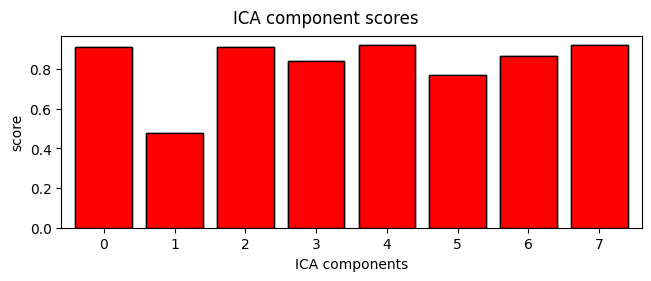

Manually found muscle artifact ICA components:      [5, 6, 7]
Automatically found muscle artifact ICA components: [0, 1, 2, 3, 4, 5, 6, 7]


In [18]:
muscle_idx_auto, scores = ica.find_bads_muscle(raw)
ica.plot_scores(scores, exclude=muscle_idx_auto)
print(
    f"Manually found muscle artifact ICA components:      {muscle_idx}\n"
    f"Automatically found muscle artifact ICA components: {muscle_idx_auto}"
)

## References

Dhani Dharmaprani, Hoang K. Nguyen, Trent W. Lewis, Dylan DeLosAngeles, John O. Willoughby, and Kenneth J. Pope. A comparison of independent component analysis algorithms and measures to discriminate between EEG and artifact components. In 2016 38th Annual International Conference of the IEEE Engineering in Medicine and Biology Society (EMBC), 825–828. Orlando, FL, USA, 2016. IEEE. doi:10.1109/EMBC.2016.7590828.

